# Notebook 3: Advanced fitting and visualization

The QM9 dataset examined in notebook 2 is in some ways not realistic. Because the dataset is so large and combinatorically generated, it is very rich. The molecules involved are also not too large. In many real-world tasks it is not so easy to have this much data, and real-world molecules are often far larger.

Here we deal with a more practical size dataset and explore how to fit to it in more detail. We avoid overfitting using the classic technique of ridge regression with internal cross-validation.

We also look at how to leverage graphlet fingerprints to identify new structural information in test data.

## Demo Data

We will use a dataset from [PyTDC](https://tdcommons.ai/) for this demonstration. 

**Warning:** the following cell will install tdc if you don't have it already!

In [1]:
try:
    import tdc
except ImportError:
    !pip install PyTDC
    import tdc

In [2]:
from tdc.single_pred import ADME
import pandas as pd

data = ADME(name = 'Lipophilicity_AstraZeneca')
split = data.get_split(method = 'scaffold',seed=42)
train, valid, test = split['train'], split['valid'], split['test']
train=pd.concat([train,valid])

Found local copy...
Loading...
Done!
100%|██████████| 4200/4200 [00:01<00:00, 2779.44it/s]


## Inspecting the data

In [3]:
train.head()

,Drug_ID,Drug,Y
0,CHEMBL1951894,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc...,3.21
1,CHEMBL1951893,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc...,2.67
2,CHEMBL197536,O=c1cc(N2CCOCC2)oc2cc(O)ccc12,1.00
3,CHEMBL1807852,C[C@H]1O[C@@H](n2cnc3c(N)nc(OC4CC5CC5C4)nc32)[...,1.66
4,CHEMBL23,COc1ccc([C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2...,1.99


In [4]:
train.shape, test.shape

((3360, 3), (840, 3))

As usual, we need to convert the molecule from Smiles strings:

In [5]:
from rdkit.Chem import MolFromSmiles,AddHs
train['mol'] = train['Drug'].map(MolFromSmiles)
test['mol'] = test['Drug'].map(MolFromSmiles)

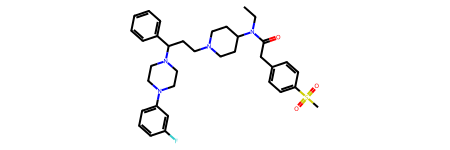

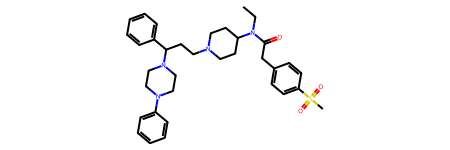

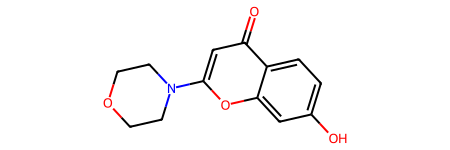

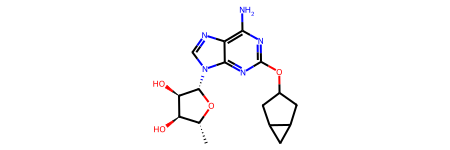

In [6]:
from IPython.display import display
n_molecules_to_display = 4
for m in train['mol'][:n_molecules_to_display]:
    display(m)

We can see that the molecules in this dataset are far larger than in QM9, and that the dataset size is far smaller. This will have practical consequences for our fits.

## Transforming data for fingerprinting

We start by featurizing the molecules as before. (This takes about two minutes with max_len=7).

In [7]:
from minervachem.transformers import FingerprintFeaturizer
import minervachem.fingerprinters as fps


fingerprinter = FingerprintFeaturizer(
    fps.GraphletFingerprinter(
        max_len=7, 
        useHs=True # Note: in this notebook, we use the `useHs` argument to have explicit hydrogens.
    ),
    n_jobs=-3, # If your computer experiences memory problems, you can set the number of jobs lower.
    verbose=1,
    chunk_size='auto',
)

In [8]:
X_train = fingerprinter.fit_transform(train['mol'])
X_train

Finding fingerprints in fit


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 254 concurrent workers.


Constructing Fingerprints:   0%|          | 0/3360 [00:00<?, ?it/s]

[Parallel(n_jobs=-3)]: Done 292 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-3)]: Done 742 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-3)]: Done 1292 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-3)]: Done 1942 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-3)]: Done 2692 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-3)]: Done 3360 out of 3360 | elapsed:   42.3s finished


N bits: 72449
Converting bits to array form


Converting FPs to sparse:   0%|          | 0/3360 [00:00<?, ?it/s]

Sparse Transform time: 0.000701 s/mol


<3360x72449 sparse matrix of type '<class 'numpy.int64'>'
	with 2852969 stored elements in Compressed Sparse Row format>

## Finding fragments that are new in test data 
One more advanced feature is to look at the fragments which show up in the test set, but not in the training set.  We call these "unseen bits".

When called with return_unseen=True, the fingerprinter will construct a second feature matrix for these new fragments. 

In [9]:
X_test, X_unseen = fingerprinter.transform(test['mol'], return_unseen=True)

finding fingerprints in transform


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 254 concurrent workers.


Constructing Fingerprints:   0%|          | 0/840 [00:00<?, ?it/s]

[Parallel(n_jobs=-3)]: Done 292 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-3)]: Done 840 out of 840 | elapsed:    8.4s finished


Converting bits to array form


Converting FPs to sparse:   0%|          | 0/840 [00:00<?, ?it/s]

Converting unseen bits to array form


Converting FPs to sparse:   0%|          | 0/840 [00:00<?, ?it/s]

The fingerprinter will also track the `bit_sizes`, the `bit_map`, and etc for the unseen bits.

In [10]:
fingerprinter.bit_sizes_unseen_, len(fingerprinter.bit_sizes_unseen_),len(fingerprinter.bit_indices_unseen_)

(array([1, 2, 3, ..., 7, 7, 7]), 4675, 4675)

In [11]:
import numpy as np
test_mols_all_seen = np.asarray(X_unseen.sum(axis=1)==0).flatten() # X_unseen is a Matrix dtype, we want array.

percent_no_novelty=100*test_mols_all_seen.sum(axis=0).item()/X_unseen.shape[0]
percent_with_novelty=100*(~test_mols_all_seen).sum(axis=0).item()/X_unseen.shape[0]
print(percent_no_novelty," percent of molecules with no unseen bits")
print(percent_with_novelty," percent of molecules with some unseen bits")

56.666666666666664  percent of molecules with no unseen bits
43.333333333333336  percent of molecules with some unseen bits


Let's examine this first unseen-during-training fragment of size 1:

In [12]:
unseen_bits_of_interest = [0] # which columns of X_unseen to examine.
#unseen_bits_of_interest = [0,1,2,3,4,5,6] # an alternative choice of which columns of X_unseen to examine.

The bit label is:

In [13]:
fingerprinter.bit_ids_unseen_[unseen_bits_of_interest[0]]

(1, 17175102577994029359)

We can find things that include the fragment corresponding to this bit:

In [14]:
interesting_molecules = np.nonzero(X_unseen[:,unseen_bits_of_interest])[0]
interesting_molecules = set(interesting_molecules)
interesting_molecules

{775}

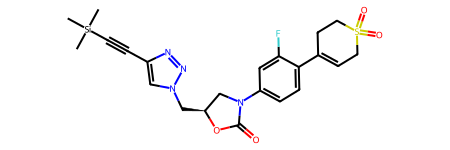

In [15]:
for mol_index in interesting_molecules:
    display(test.iloc[mol_index].mol)

But which part of this large molecule is novel?

To examine the question, we will set an attribute array for the fragments which is 0 for known fragments in the training set, but 1 for fragments that only appear in the test set.

In [16]:
# Zero for every feature in the training set, one for features that are only in the test set.
coef=[0]*len(fingerprinter.bit_ids_)+[1]*len(fingerprinter.bit_ids_unseen_)

# A list of the bit keys corresponding to each of the above values.
bit_ids=fingerprinter.bit_ids_+fingerprinter.bit_ids_unseen_

We then use the intepretability projections (see notebook 2) for this attribute to locate the unseen bits in our `interesting_molecules` list.

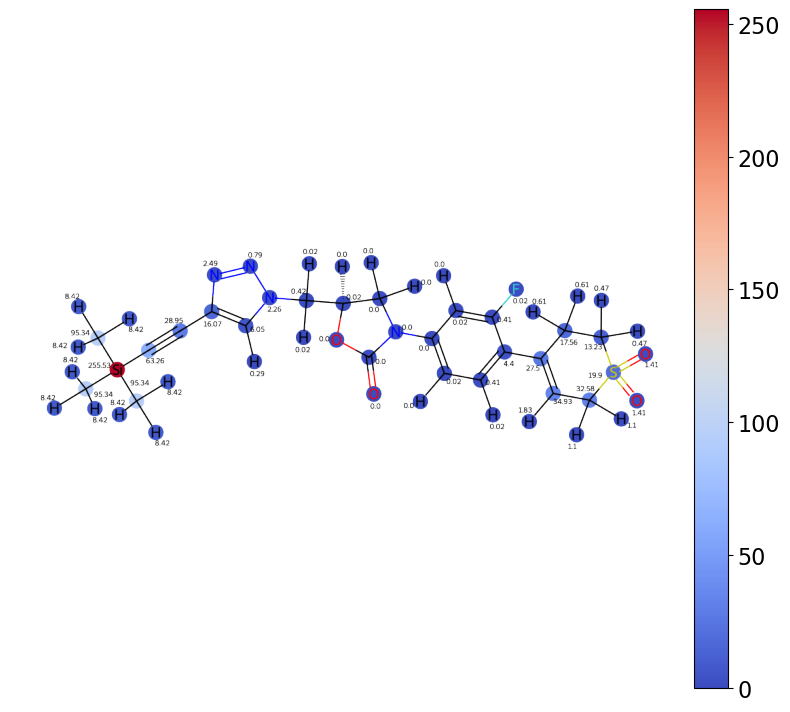

unseen bits: 898
775


In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
from minervachem.graphlet_dags import GraphletDAG, draw_projected_coefs


for mol_index in interesting_molecules:
    # Note: b/c we did not AddH to the training/testing sets, but the fingerprinter has 
    # useHs=True, we need to AddHs to the molecules here for visualization.
    # Otherwise the code will fail!
    mol_with_h = AddHs(test.iloc[mol_index].mol)
    dag=GraphletDAG(mol_with_h,
                    fingerprinter=fingerprinter.fingerprinter,
                    bit_ids=bit_ids,
                    coef=coef,  
                    )
    draw_projected_coefs([dag],
                         level=1, 
                         figsize=(8,8),
                         ncol=1,
                         cmap='coolwarm',
                         dpi=1000,
                         svgsize=(1000, 1000),
                    )
    plt.tight_layout()
    plt.show()
    print("unseen bits:",X_unseen[mol_index].sum())
    print(mol_index)

Evidently, the Silicon Atom is the locus of new information - the training set does not contain any of these!

If you like, go back to the cell defining `unseen_bits_of_interest` and modify it to look at additional molecules from the test set which contain new types of subgraphs.

## A basic fit, and overfitting

In [18]:
from sklearn.linear_model import Ridge

In [19]:
model = Ridge(alpha=1e4,solver='sparse_cg',tol=1e-5)

In [20]:
%%time
model.fit(X_train, train['Y'])

CPU times: user 22.7 s, sys: 1min 54s, total: 2min 17s
Wall time: 1.43 s


Ridge(alpha=10000.0, solver='sparse_cg', tol=1e-05)

In [21]:
from minervachem.plotting import parity_plot_train_test

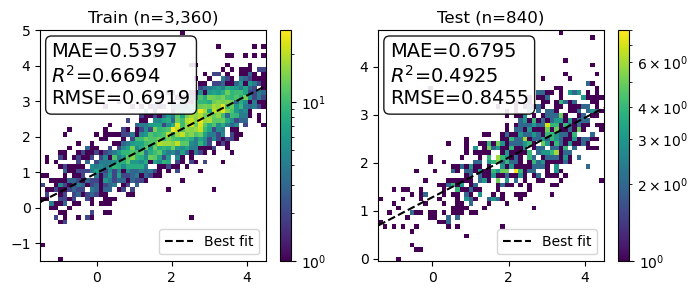

In [22]:
parity_plot_train_test([X_train, X_test], 
                       [train['Y'], test['Y']], 
                       model)
plt.show()

Unfortunately, the performance of the model is strongly dependent on `alpha`:

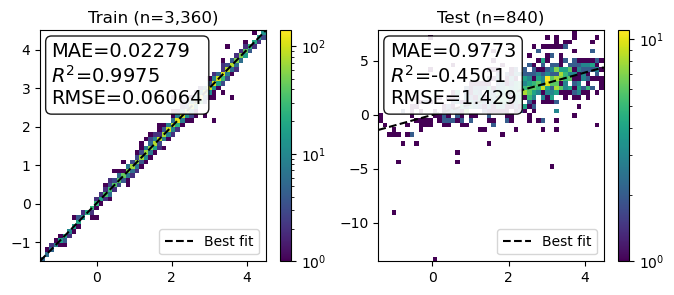

CPU times: user 1h 39min 44s, sys: 8h 35s, total: 9h 40min 20s
Wall time: 4min 33s


In [23]:
%%time 
model = Ridge(alpha=0.1,solver='sparse_cg',tol=1e-5)
model.fit(X_train, train['Y'])
parity_plot_train_test([X_train, X_test], 
                       [train['Y'], test['Y']], 
                       model)
plt.show()

Notice that in this case, the overfitting is extremely severe! We need to do something about this.

## Avoiding overfitting with internal cross-validation

To avoid this problem, we can use internal [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html) on the dataset, using the scikit-learn GridSearchCV object, for example.

We will apply the GridSearchCV in the context of the hierarchical residual model, because the `alpha` value tends to depend on the size of the fragments used as features. The fitting will take a couple of minutes.

In [24]:
from minervachem.regressors import HierarchicalResidualModel
import sklearn.model_selection
import numpy as np

base_model = Ridge(alpha=1e2,solver='sparse_cg',tol=1e-5)
param_grid = {'alpha':10.**np.arange(-1,9,1/3)} # a range of alpha values to search

cv_search = sklearn.model_selection.GridSearchCV(estimator=base_model,
                                                 param_grid=param_grid,
                                                 refit=True,
                                                 verbose=1,
                                                 n_jobs=-3)

hmodel = HierarchicalResidualModel(cv_search,verbose=True)

In [25]:
%%time
hmodel.fit(X_train, train['Y'],levels=fingerprinter.bit_sizes_)

Regressor levels::   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
CPU times: user 13.9 s, sys: 54.3 s, total: 1min 8s
Wall time: 1min 7s


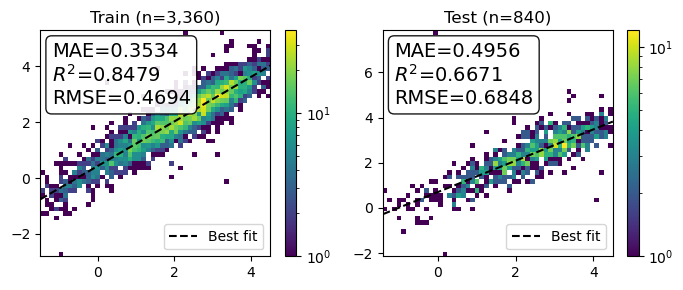

In [26]:
parity_plot_train_test([X_train, X_test], 
                       [train['Y'], test['Y']], 
                       hmodel,
                      figsize=(7,3))
plt.tight_layout()
plt.show()

Nice! Now we see that the performance is good, and additionally, the model does not overfit by nearly as much.

How does this result compare to [the leaderboard](https://tdcommons.ai/benchmark/admet_group/05lipo/)? Not bad for a method that runs in minutes!

At each hierarchical level, a separate value of $\alpha$ has been determined:

In [27]:
{level:x.alpha for level,x in hmodel.regressors.items()}

{1: 0.46415888336127775,
 2: 21.54434690031882,
 3: 21.54434690031882,
 4: 21.54434690031882,
 5: 464158883.3612754,
 6: 464.1588833612773,
 7: 464158883.3612754}

It is typical that larger values of $\alpha$ will be better for the larger-sized fragments.

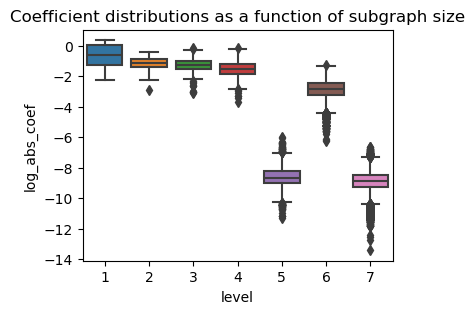

In [28]:
fig, ax = plt.subplots(figsize=(4,3))
hmodel.plot_coefs()
plt.title("Coefficient distributions as a function of subgraph size")
plt.show()

The coefficient distributions likewise show that using too large of a fragment does not improve the model performance. Luckily, the HierarchicalResidualModel in combination with the RidgeCV can automatically discover this.

## Comparing the test performance on molecules without and with unseen bits

Let's break up the test performance into two groups.

- Group 1: Test molecules where the fingerprinter did not find any novel bits compared to the training set.
- Group 2: Test molecules where novel bits do arise, meaning that there is some subgraph structure that was not found in the training set.

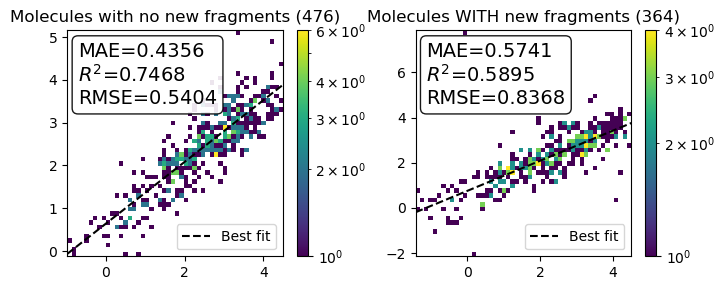

In [29]:
parity_plot_train_test([X_test[test_mols_all_seen], X_test[~test_mols_all_seen]], 
                       [test['Y'][test_mols_all_seen], test['Y'][~test_mols_all_seen]], 
                       hmodel,
                      figsize=(7,3))
fig = plt.gcf()
ax_left,ax_right = map(lambda i:fig.get_axes()[i], [0,1])
plt.sca(ax_left)
plt.title(f"Molecules with no new fragments ({test_mols_all_seen.sum()})")
plt.sca(ax_right)
plt.title(f"Molecules WITH new fragments ({(~test_mols_all_seen).sum()})")
plt.tight_layout()
plt.show()

We can see that the model actually does noticeably better on the sub-population of data where new information is not present.

This is a useful result! The model is interpretable enough for us to identify where it is likely to fail: we can can compare the fingerprint of new molecules to the set of bits in the training set. This will tell us if there is any new topological information, up to the subgraph size considered by this fingerprinter. If there is new topology, it is more likely that the model performs poorly.